In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("data/record-[2018.11.16-10.16.29].csv");
data = raw_data.drop(["Event Id",
                      "Event Date",
                      "Event Duration",
                      "Epoch",
                      "Channel 1",
                      "Channel 4",
                      "Channel 5",
                      "Channel 9",
                      "Channel 12",
                      "Channel 13",
                      "Channel 15",
                      "Channel 16",
                      "Time:512Hz"], axis=1)
del raw_data;
fs_data = 512;

blink_data = pd.read_csv('matlab/sub12Trial02.csv', header=None);
fs_blink = 256;

In [3]:
data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
data.head()

mean_data = np.absolute(data).mean().mean()

data = 1000*data

In [4]:
blink_data.head()
#mean_blink = np.absolute(blink_data).mean().mean()
#blink_data = blink_data/mean_blink

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,72.281,-22.081,-18.261,-42.926,-37.048,-45.349,-45.712,-43.485,-37.650,-37.808,-39.964,-40.085,-42.003,-37.128,-45.527
1,71.426,-24.315,-20.104,-45.788,-37.860,-45.871,-46.642,-45.431,-38.041,-39.742,-41.318,-40.200,-42.509,-36.331,-42.929
2,69.907,-24.131,-20.140,-47.145,-37.896,-47.838,-48.028,-46.926,-37.772,-39.375,-42.551,-40.227,-43.248,-35.844,-41.576
3,67.868,-21.559,-18.199,-46.074,-36.451,-49.555,-48.664,-46.907,-36.189,-36.810,-42.512,-39.882,-43.484,-35.147,-41.361
4,66.621,-18.828,-16.001,-43.409,-33.966,-48.125,-47.397,-45.316,-34.005,-34.121,-40.562,-39.343,-42.957,-33.950,-41.707


In [5]:
from scipy.signal import decimate
r = int(np.ceil(fs_data/fs_blink));
fs = fs_data/r;
ts = 1/fs;

signal_data = decimate(data.T, r, ftype='fir', n=2000, zero_phase=True);
comp_data = blink_data.T.values

if(len(signal_data[1,:]) != len(comp_data[1,:])):
    if(len(signal_data[1,:]) > len(comp_data[1,:])):
        n = len(comp_data[1,:]);
        signal_data = signal_data[:, 0:n]
    else:
        n = len(signal_data[1,:]);
        comp_data = comp_data[:, 0:n]

t = np.arange(0,n)/fs;

In [50]:
from sklearn.decomposition import FastICA

ica = FastICA(random_state=457522)
S = ica.fit_transform(list(map(list, zip(*signal_data))))
signal_ica = np.array(list(map(list, zip(*S))))

plt.plot(signal_ica[2])

plt.plot(signal_data[2])

In [14]:
import pywt

freqs = pywt.scale2frequency('morl', np.arange(5,450))*fs

fwindow = [[7,35], [4,7], [0.5, 4]];
twindow = [30, 50];

fmask = [[x >= f[0] and x < f[1] for x in freqs] for f in fwindow]
tmask = [x >= twindow[0] and x < twindow[1] for x in t]

channels_sig = [0,2]
channels_blk = [0,1]

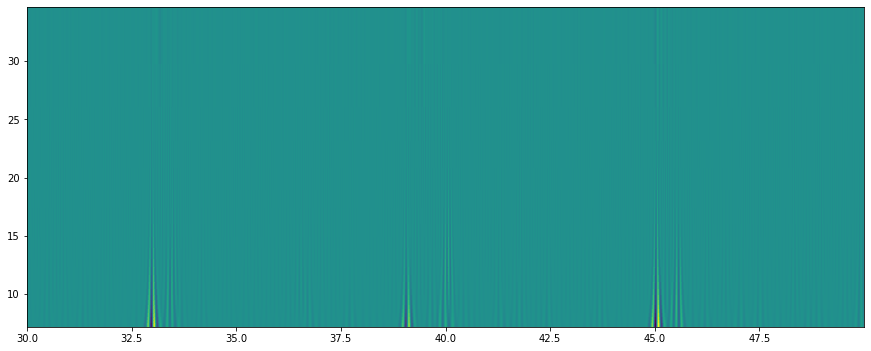

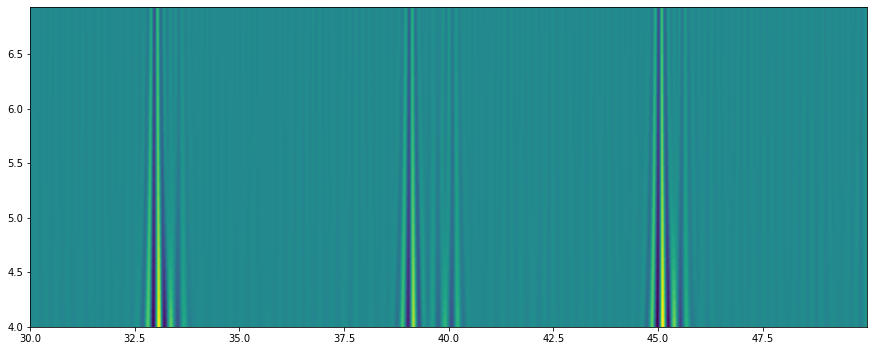

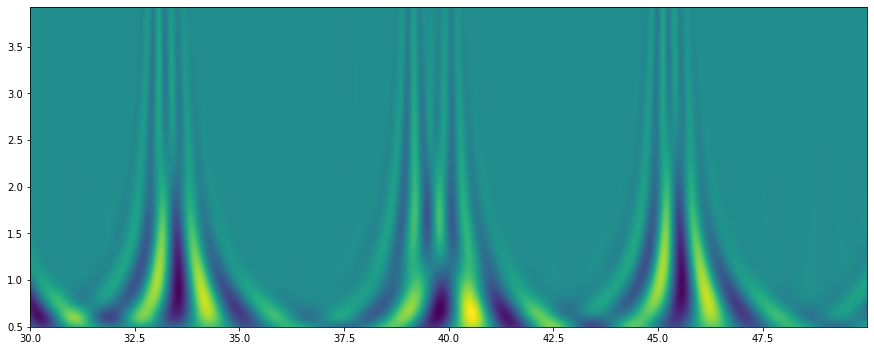

In [17]:
csample_blk, freqs = pywt.cwt(comp_data[0, :], np.arange(5,450), 'morl', sampling_period=ts)
for i in range(0, len(fwindow)):
    plt.figure(figsize=(15,20))
    plt.subplot(len(fwindow), 1, i+1)
    plt.pcolormesh(t[tmask], freqs[fmask[i]], csample_blk[np.ix_(fmask[i],tmask)])
    plt.show();

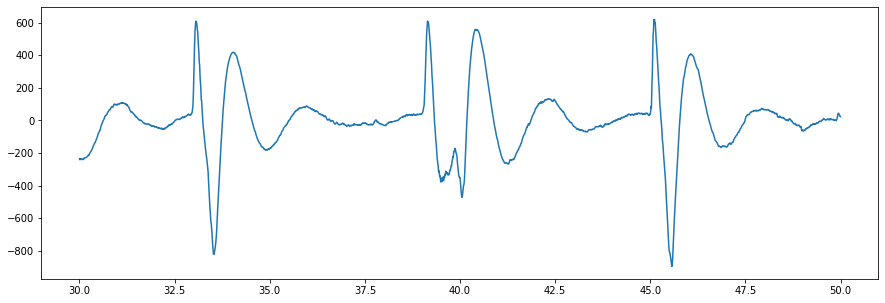

In [21]:
plt.figure(figsize=(15,5))
plt.plot(t[tmask], comp_data[0, tmask])

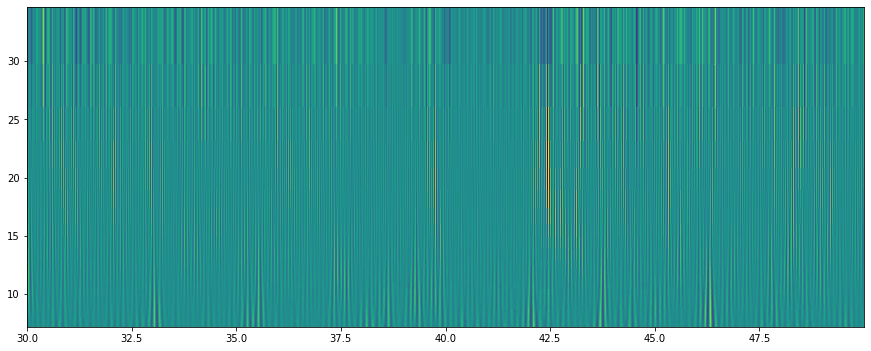

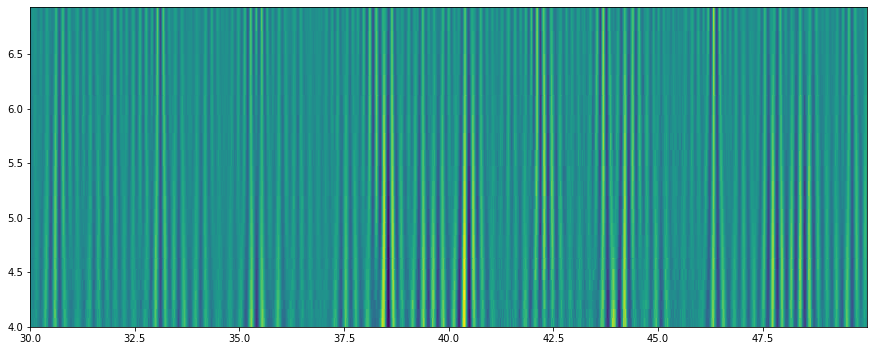

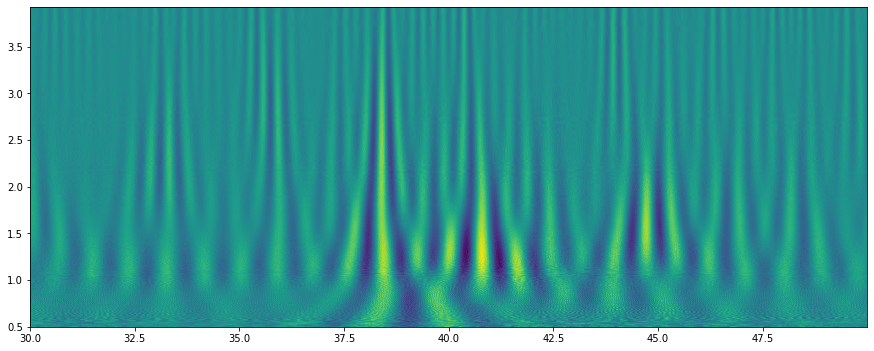

In [16]:
csample_data, freqs = pywt.cwt(signal_data[2, :], np.arange(5,450), 'morl', sampling_period=ts)
for i in range(0, len(fwindow)):
    plt.figure(figsize=(15,20))
    plt.subplot(len(fwindow), 1, i+1)
    plt.pcolormesh(t[tmask], freqs[fmask[i]], csample_data[np.ix_(fmask[i],tmask)])
    plt.show();

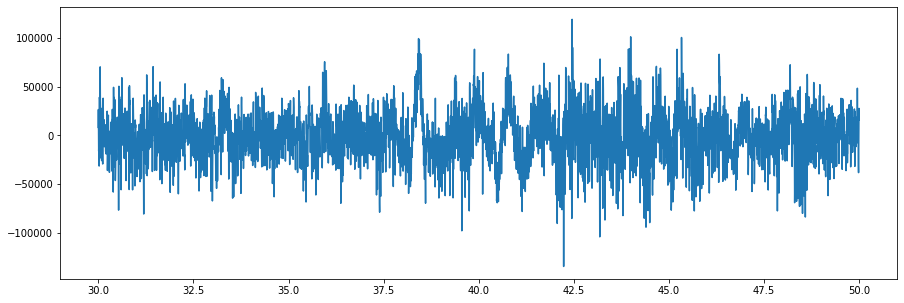

In [44]:
plt.figure(figsize=(15,5))
plt.plot(t[tmask], signal_data[2, tmask])

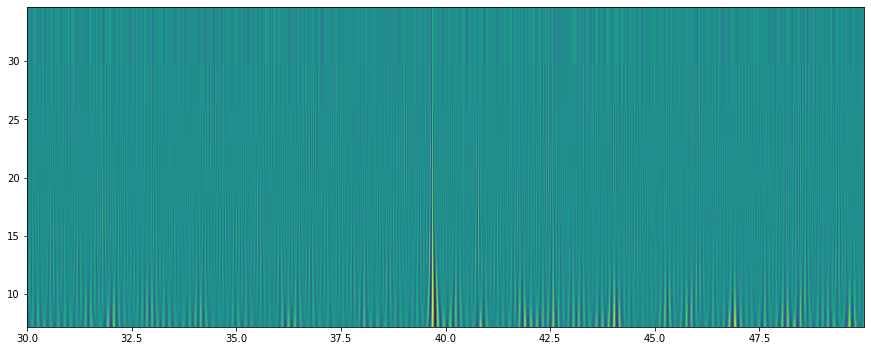

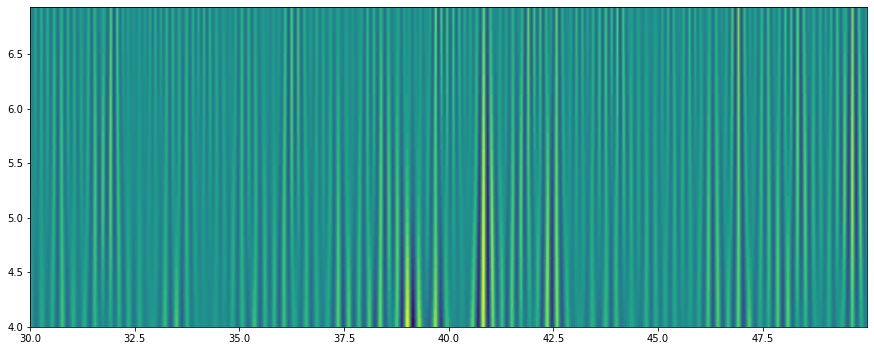

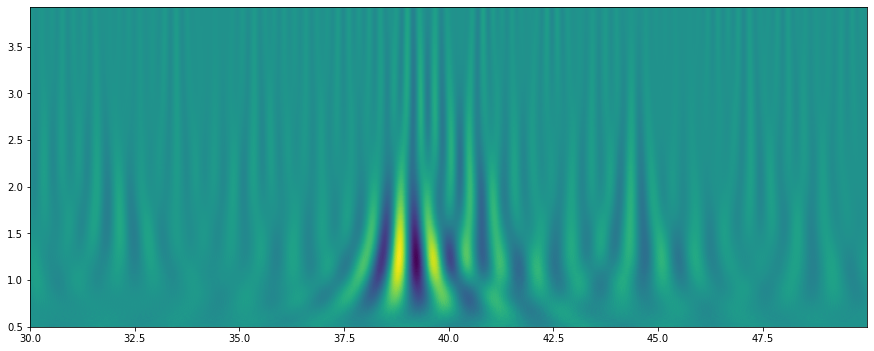

In [52]:
coef_ica, freqs = pywt.cwt(signal_ica[1], np.arange(5,450), 'morl', sampling_period=ts)
for i in range(0, len(fwindow)):
    plt.figure(figsize=(15,20))
    plt.subplot(len(fwindow), 1, i+1)
    plt.pcolormesh(t[tmask], freqs[fmask[i]], coef_ica[np.ix_(fmask[i],tmask)])
    plt.show();

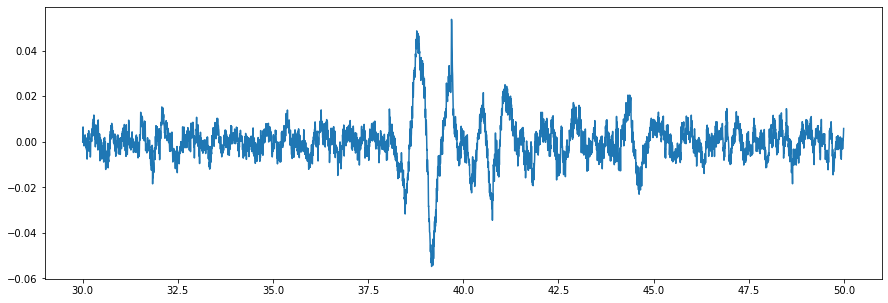

In [51]:
plt.figure(figsize=(15,5))
plt.plot(t[tmask], signal_ica[1][tmask])

In [23]:
coef_sig = np.zeros((len(channels_sig), len(freqs), len(signal_data[0])))

for x, sig in enumerate(signal_data[channels_sig, :]):
    coef_sig[x,:,:], freqs = pywt.cwt(sig, np.arange(5,450), 'morl', sampling_period=ts)
#    for i in range(0, len(fwindow)):
#        plt.subplot(len(fwindow), 1, i+1)
#        plt.pcolormesh(t[tmask], freqs[fmask[i]], coef_sig[np.ix_(fmask[i],tmask)])
#        plt.show();

In [24]:
coef_blk = np.zeros((len(channels_blk), len(freqs), len(comp_data[0])))
for x, sig in enumerate(comp_data[channels_blk, :]):
    coef_blk[x, :, :], freqs = pywt.cwt(sig, np.arange(5,450), 'morl', sampling_period=ts)
#for i in range(0, len(fwindow)):
#    plt.subplot(len(fwindow), 1, i+1)
#    plt.pcolormesh(t[tmask], freqs[fmask[i]], coef_blk[np.ix_(fmask[i],tmask)])
#    plt.show();


In [25]:
fmask_m = [f_ > 1 and f_ < 2 for f_ in freqs]
#a = coef_sig[:, fmask_m, :]
wsize = int(np.ceil(0.7*fs))
b = np.ones((sum(fmask_m), wsize))/(sum(fmask_m)*wsize);

from scipy.signal import convolve2d
med_blk = [convolve2d(np.power(s[fmask_m, :],2), b, mode='valid') for s in coef_blk]
med_sig = [convolve2d(np.power(s[fmask_m, :],2), b, mode='valid') for s in coef_sig]

In [26]:
med_blk = np.squeeze(med_blk)
med_sig = np.squeeze(med_sig)

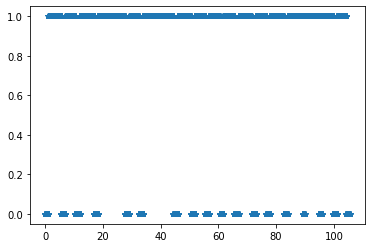

In [27]:
med_blk_t = np.array(list(map(list, zip(*med_blk))));
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)

clusters = kmeans.fit_predict(med_blk_t);

t_med = t[:-wsize+1];
tmask_m = tmask[:-wsize+1];
cmask = [c==0 for (t_, c) in zip(tmask_m, clusters)]
plt.plot(t_med, clusters, '*')

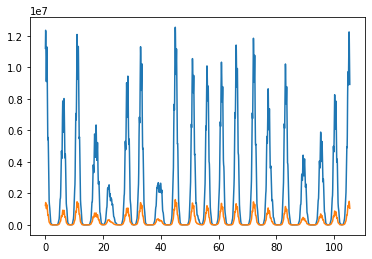

In [28]:
plt.plot(t_med, med_blk_t)

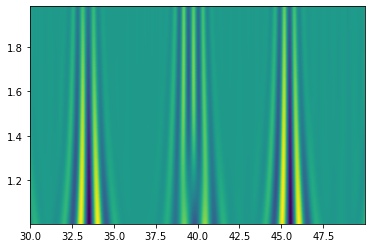

In [29]:
plt.pcolormesh(t[tmask], freqs[fmask_m], coef_blk[0][np.ix_(fmask_m,tmask)])

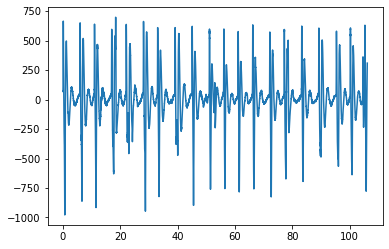

In [30]:
plt.plot(t, comp_data[0])

0


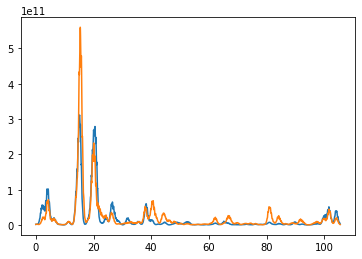

In [31]:
med_sig_t = np.array(list(map(list, zip(*med_sig))));
cl = kmeans.predict(med_sig_t)

plt.plot(t_med, med_sig_t)
print(sum(cl))

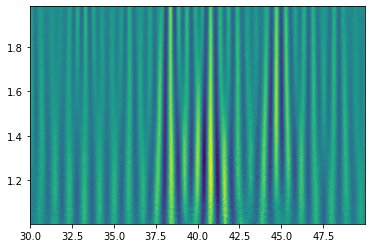

In [32]:
plt.pcolormesh(t[tmask], freqs[fmask_m], coef_sig[1][np.ix_(fmask_m,tmask)])